In [1]:
from ActiveTestingRegression import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### Nonlinear Regression - 1D data

In [2]:
rng = np.random.RandomState(2)

N = 60
data_max, data_min = 1.4, -1.4
len_data = (data_max - data_min)
data = np.sort(rng.rand(N) * len_data - len_data / 2)
noise = rng.randn(N) * 0.1
target = data ** 3 - 0.5 * data ** 2 +  noise

X, y = data, target 

# D_train and D_test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=15) # 11

# learner  
reg_learner = Pipeline([
            ("polynomial_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("std", StandardScaler()),
            ("linear_regression", Ridge())])


reg_learner.fit(X_train[:,np.newaxis], y_train)

y_pred = reg_learner.predict(X_test[:,np.newaxis])

X_new = np.linspace(-1.3,1.3,100)

# evaluator 1 
search = GridSearchCV(
    SVR(kernel="rbf"),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
    scoring='neg_root_mean_squared_error')


search.fit(X_train[:,np.newaxis], y_train)

search.best_params_

{'C': 1000.0, 'gamma': 0.1}

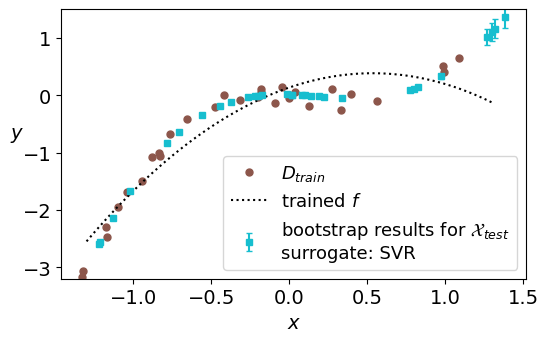

In [3]:
reg_evaluator = SVR(kernel="rbf", gamma=search.best_params_["gamma"],
                    C=search.best_params_["C"])

mean, var = find_mean_var_bootstrap(X_train[:,np.newaxis], y_train, X_test[:,np.newaxis], reg_evaluator)

probs = quadratic_loss(y_pred, mean) + var
pmf = probs / probs.sum()


# figure 
plt.rcParams.update({'font.size': 14, "figure.figsize": (6,3.5)})

plt.plot(X_train, y_train, "C5o", markersize=5, label='$D_{train}$')

plt.plot(X_new, reg_learner.predict(X_new[:,np.newaxis]), 'k:', label="trained $f$")

plt.errorbar(X_test, mean, yerr=var, ls='none', marker='s', c="C9",
             markersize=4, capsize=2, label='bootstrap results for $\mathcal{X}_{test}$\nsurrogate: SVR')


plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.legend(fontsize=13)
plt.ylim([-3.2,1.5])
fig_name = 'syn_svr_vis.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()

In [4]:
num_exp = 100 
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)

for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
        # uniform 
        observed_idx = np.random.choice(N, M, replace=False)
        weights = np.ones(M)/M 
        result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train[:,np.newaxis], y_train,
                                           X_test[:,np.newaxis], y_pred, M, reg_evaluator, loss=quadratic_loss)
        
        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

---3---
---6---
---9---
---12---
---15---


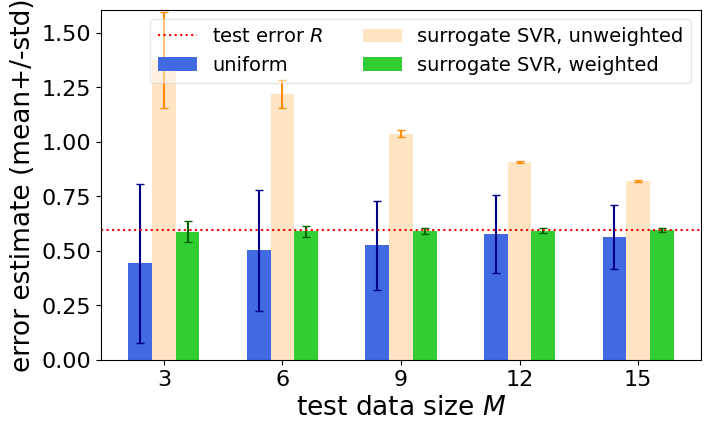

In [5]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=3)
ax.bar(M_values , result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=3)
ax.bar(M_values + calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=3)

plt.axhline(y = full_loss, color = 'r', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(0,result_mod_unweighted.max())
ax.legend(labels=['test error $R$', 'uniform', 'surrogate SVR, unweighted',  'surrogate SVR, weighted'], ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'syn_svr_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()

In [6]:
# evaluator 2 
search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={"n_neighbors": [2,4,6,8,10], "weights": ['uniform', 'distance']},
    scoring='neg_root_mean_squared_error')


search.fit(X_train[:,np.newaxis], y_train)

search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

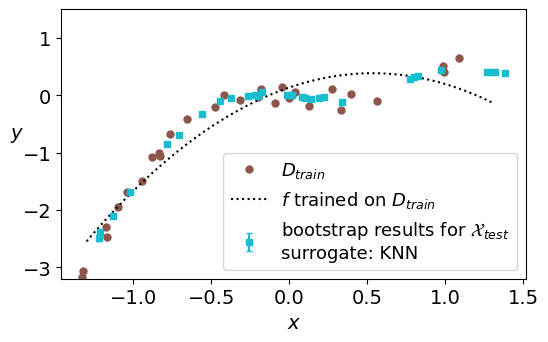

In [7]:
reg_evaluator = KNeighborsRegressor(n_neighbors=search.best_params_['n_neighbors'],
                                   weights=search.best_params_['weights'])

mean, var = find_mean_var_bootstrap(X_train[:,np.newaxis], y_train, X_test[:,np.newaxis], reg_evaluator)

probs = quadratic_loss(y_pred, mean) + var
pmf = probs / probs.sum()


# figure 
plt.rcParams.update({'font.size': 14, "figure.figsize": (6,3.5)})

plt.plot(X_train, y_train, "C5o", markersize=5, label='$D_{train}$')

plt.plot(X_new, reg_learner.predict(X_new[:,np.newaxis]), 'k:', label="$f$ trained on $D_{train}$")

plt.errorbar(X_test, mean, yerr=var, ls='none', marker='s', c="C9",
             markersize=4, capsize=2, label='bootstrap results for $\mathcal{X}_{test}$\nsurrogate: KNN')


plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.legend(fontsize=13)
plt.ylim([-3.2,1.5])
fig_name = 'syn_knn_vis.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()

In [8]:
num_exp = 100 
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
#result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)

for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
#         # uniform 
#         observed_idx = np.random.choice(N, M, replace=False)
#         weights = np.ones(M)/M 
#         result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
#                        weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train[:,np.newaxis], y_train,
                                           X_test[:,np.newaxis], y_pred, M, reg_evaluator, loss=quadratic_loss)
        
        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

---3---
---6---
---9---
---12---
---15---


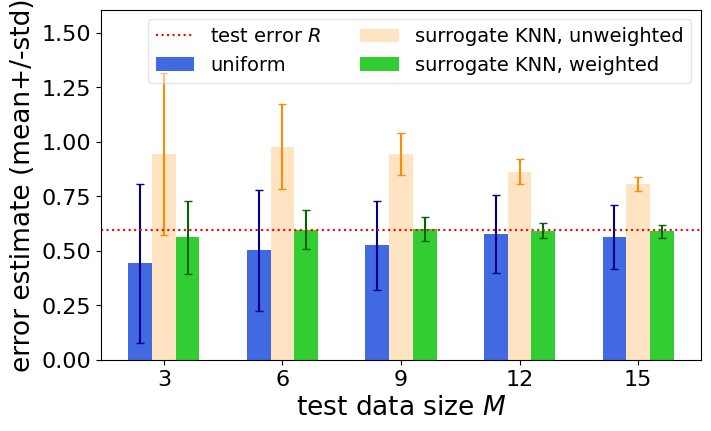

In [9]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=3)
ax.bar(M_values , result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=3)
ax.bar(M_values + calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=3)

plt.axhline(y = full_loss, color = 'r', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(0,result_mod_unweighted.max())
ax.legend(labels=['test error $R$', 'uniform', 'surrogate KNN, unweighted',  'surrogate KNN, weighted'], ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'syn_knn_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()

### Real problem 1

In [26]:
df = pd.read_excel('ENB2012_data.xlsx')

X = df.iloc[:,:7].to_numpy()

y = df['Y1'].to_numpy()

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

# D_train and D_test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=15) # 11

# train 
reg_learner = Pipeline([
            ("polynomial_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("std", StandardScaler()),
            ("linear_regression", Ridge())])


reg_learner.fit(X_train, y_train)

y_pred = reg_learner.predict(X_test)

# evaluator 1 
search = GridSearchCV(
    SVR(kernel="rbf"),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
    scoring='neg_root_mean_squared_error')


search.fit(X_train, y_train)

search.best_params_

{'C': 1000.0, 'gamma': 0.1}

In [11]:
reg_evaluator = SVR(kernel="rbf", gamma=search.best_params_["gamma"],
                    C=search.best_params_["C"])

In [12]:
num_exp = 100
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)

for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
        # uniform 
        observed_idx = np.random.choice(N, M, replace=False)
        weights = np.ones(M)/M 
        result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train, y_train,
                                           X_test, y_pred, M, reg_evaluator, loss=quadratic_loss)
        
        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

---38---
---76---
---115---
---153---
---192---


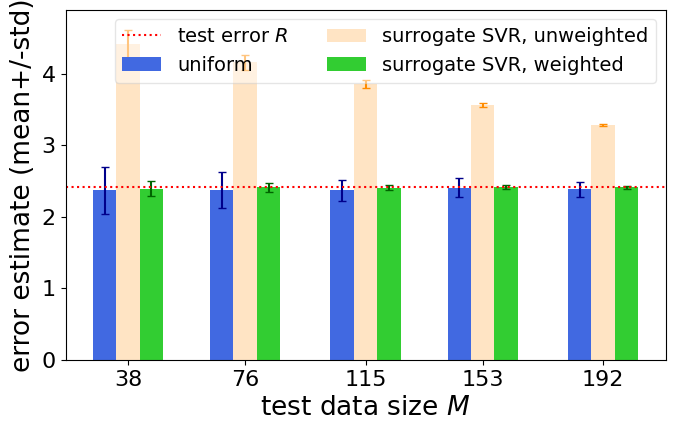

In [14]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=3)
ax.bar(M_values , result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=3)
ax.bar(M_values + calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=3)

plt.axhline(y = full_loss, color = 'r', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(0,result_mod_unweighted.max())
ax.legend(labels=['test error $R$', 'uniform', 'surrogate SVR, unweighted',  'surrogate SVR, weighted'], ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'energy_svr_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()

In [15]:
# evaluator 2 
search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={"n_neighbors": [2,4,6,8,10], "weights": ['uniform', 'distance']},
    scoring='neg_root_mean_squared_error')


search.fit(X_train, y_train)

search.best_params_

{'n_neighbors': 8, 'weights': 'distance'}

In [16]:
reg_evaluator = KNeighborsRegressor(n_neighbors=search.best_params_['n_neighbors'],
                                   weights=search.best_params_['weights'])

In [17]:
num_exp = 100
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
#result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)

for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
#         # uniform 
#         observed_idx = np.random.choice(N, M, replace=False)
#         weights = np.ones(M)/M 
#         result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
#                        weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train, y_train,
                                           X_test, y_pred, M, reg_evaluator, loss=quadratic_loss)
        
        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

---38---
---76---
---115---
---153---
---192---


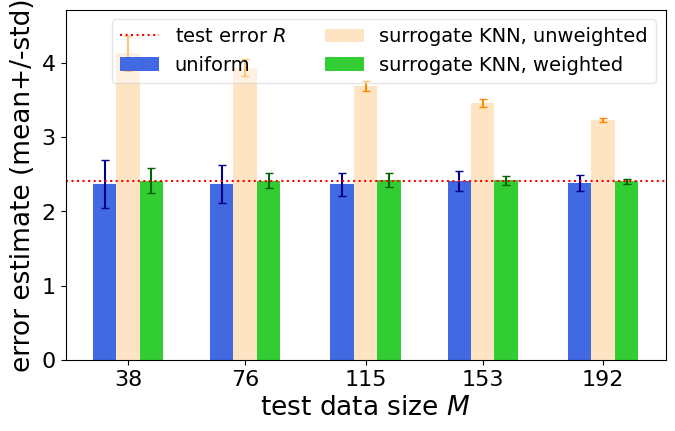

In [19]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=3)
ax.bar(M_values , result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=3)
ax.bar(M_values + calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=3)

plt.axhline(y = full_loss, color = 'r', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(0,result_mod_unweighted.max())
ax.legend(labels=['test error $R$', 'uniform', 'surrogate KNN, unweighted',  'surrogate KNN, weighted'], ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'energy_knn_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()

In [24]:
result_mod_weighted.std(axis=0)

array([0.1674794 , 0.10395535, 0.09248174, 0.06029157, 0.03743241])

In [23]:
full_loss

2.4078988471573908

### Real problem 2

https://www.kaggle.com/code/nityasreepaladugu/predicting-concrete-compressive-strength-with-ml/notebook

In [30]:
data = pd.read_csv("DataConc.csv")

data.head()

,Cement (component 1)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,162.0,676.0,1040.0,0.0,0.0,2.5,28,79.99
1,540.0,162.0,676.0,1055.0,0.0,0.0,2.5,28,61.89
2,332.5,228.0,594.0,932.0,0.0,142.5,0.0,270,40.27
3,332.5,228.0,594.0,932.0,0.0,142.5,0.0,365,41.05
4,198.6,192.0,825.5,978.4,0.0,132.4,0.0,360,44.30


In [31]:
X = data.iloc[:,:-1].to_numpy()         # Features - All columns but last
y = data.iloc[:,-1].to_numpy()          # Target - Last Column

In [32]:
X.shape, y.shape

((1030, 8), (1030,))

In [33]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

X = StandardScaler().fit_transform(X)

# D_train and D_test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1) # 15

# train 
reg_learner = DecisionTreeRegressor()


reg_learner.fit(X_train, y_train)

y_pred = reg_learner.predict(X_test)

# evaluator 1 

# search = GridSearchCV(
#     SVR(kernel="rbf"),
#     param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
#     scoring='neg_root_mean_squared_error')


# search.fit(X_train, y_train)

# search.best_params_

In [34]:

reg_evaluator = RandomForestRegressor(n_estimators=10)


#reg_evaluator = SVR(kernel="rbf", gamma=search.best_params_["gamma"],
#                    C=search.best_params_["C"])

In [35]:
num_exp = 100
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)

for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
        # uniform 
        observed_idx = np.random.choice(N, M, replace=False)
        weights = np.ones(M)/M 
        result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train, y_train,
                                           X_test, y_pred, M, reg_evaluator, loss=quadratic_loss)
        
        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

---51---
---103---
---154---
---206---
---257---


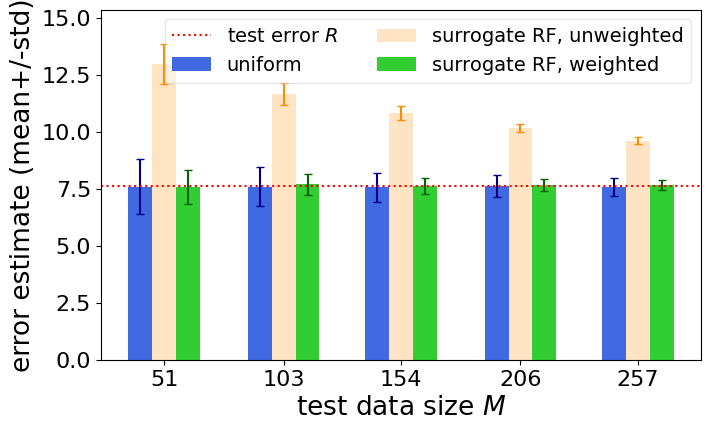

In [36]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=3)
ax.bar(M_values , result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=3)
ax.bar(M_values + calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=3)

plt.axhline(y = full_loss, color = 'r', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(0,result_mod_unweighted.max())
ax.legend(labels=['test error $R$', 'uniform', 'surrogate RF, unweighted',  'surrogate RF, weighted'], ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'concrete_RF_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()


In [41]:
result_uni.std(axis=0)

array([1.21944133, 0.86437811, 0.64087564, 0.48673754, 0.40147087])

In [40]:
result_mod_weighted.std(axis=0)

array([0.75327656, 0.47263162, 0.35905266, 0.25164542, 0.21236196])

In [42]:
full_loss

7.631719105473836

In [44]:
# evaluator 2 

# from sklearn.ensemble import ExtraTreesRegressor

# reg_evaluator = ExtraTreesRegressor(n_estimators=100)

# from sklearn.ensemble import BaggingRegressor

# from sklearn.tree import ExtraTreeRegressor

# reg_evaluator = BaggingRegressor(ExtraTreeRegressor())

from sklearn.ensemble import AdaBoostRegressor

reg_evaluator = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), n_estimators=10)


In [45]:
num_exp = 100
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
#result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)

for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
#         # uniform 
#         observed_idx = np.random.choice(N, M, replace=False)
#         weights = np.ones(M)/M 
#         result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
#                        weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train, y_train,
                                           X_test, y_pred, M, reg_evaluator, loss=quadratic_loss)
        
        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

---51---
---103---
---154---
---206---
---257---


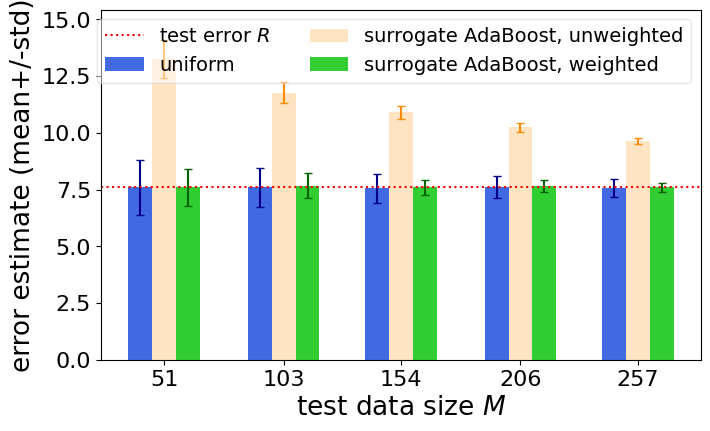

In [46]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=3)
ax.bar(M_values , result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=3)
ax.bar(M_values + calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=3)

plt.axhline(y = full_loss, color = 'r', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(0,result_mod_unweighted.max())
ax.legend(labels=['test error $R$', 'uniform', 'surrogate AdaBoost, unweighted',  'surrogate AdaBoost, weighted'], ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'concrete_Ada_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()

In [50]:
np.mean(result_uni.std(axis=0)/result_mod_weighted.std(axis=0))

1.7710820847910895

In [48]:
result_mod_weighted.std(axis=0)

array([0.82065305, 0.54665505, 0.34528733, 0.27517442, 0.1855775 ])